# Oblate Stars

This tutorial will show how to use `pavpy` to analyse PAVO observations of the rapid rotator $\upsilon$ UMa.

## Background - PAVO data reduction

The raw data from the PAVO beam combiner is a sequence of FITS files. On a typical night, ~25,000 such files may be created, although on an excellent night it may be many more. Ideally, these images will contain images of the PAVO pupil with interference fringes present, but quite often they are not, such are the challenges of long-baseline optical interferometry. The raw data are stored in the CHARA archive, and can be accessed through the Remote Data Reduction Machine (https://www.chara.gsu.edu/observers/data-reduction-software). Alternatively, the archive can be searched here: http://db.chara-array.org:8080/.

The PAVO Data Reduction Pipeline takes the raw images and ultimately determines calibrated squared visibilities ($V^2$) of target stars, and the angular diameter that best fits these visibility measurements. There are several steps in the reduction, and a tutorial for using the pipeline can be found here: https://www.chara.gsu.edu/tutorials/pavo-data-reduction.

The pipeline is written in IDL. This is unfortunate for a number of reasons. IDL requires a license, which may not be readily available. Additionally, the astronomy community has been moving away from IDL towards more widely used languages such as Python. This limits the opportunities for further development of the pipeline. It's particularly frustrating for trying to analyse targets that have morphologies any more complicated than a linearly limb-darkened disc.

Ideally, we would like to analyse PAVO observations in Python but, ideally we would also like to avoid rewriting the entire PAVO pipeline in Python. 

We *could* just use the calibrated visibilites produced by the pipeline. These can be output from `l1_l2_gui.pro`, the final program in the pipeline (see the [Tutorial](https://www.chara.gsu.edu/tutorials/pavo-data-reduction)), in a text file format. A (Python!) script also exists to convert this to the [OIFITS format](https://www.chara.gsu.edu/analysis-software/oifits-data-format). That said, there is information that is lost in these calibrated visibilities. Of particular concern is that the calibrated $V^2$ measurements are correlated because, amongst other things, they are calibrated with the same calibrator star(s). We would therefore prefer to use less calibrated data than this so we can better account for possible systematics.

The penultimate step of the pipeline is `l0_l1_gui.pro`. This step involves flagging and removing poor measurements, and then computing the uncalibrated visibilites of the target and calibrator scans. The uncalibrated visibilities are output to text files. Several other files for each scan are also output in XDR (eXternal Data Representation) format. Notably, one of these XDR files contains the covariance matrix of the uncalibrated visibilities between the different wavelength channels. It's therefore the output from this step of the pipeline that is probably the best place to take the data for our further analysis.

There is one earlier step in the pipeline, `processv2.pro`. This step takes the FITS images from the camera and calculates raw visibilities for each frame, which are then saved in XDR format. The only benefit in going back to the results from this step is that it allows different choices to then be made in which frames get included in calculating the uncalbrated visibilites, for example, what S/N cuts to make.

In summary, these are the files created by each step of the pipeline:
* **`processv2.pro`**
    * `*.pav` files: *XDR file created in IDL that includes details of the array configuration and the raw $V^2$ measurements for each frame of each scan*
* **`l0_l1_gui.pro`** \
A text file containing a list of `*.pav` files to be analysed is created called, e.g. `pavlist`. Then, for each `*.pav` file, `l0_l1_gui.pro` generates:
    * `*.pav.cov` files: *XDR files that contain the covariance matrix of the uncalibrated $V^2$ measurements across wavelength channels for each scan*
    * `*.pav.ind` files: *XDR files that record which frames are included in the calculation of the uncalibrated $V^2$ for each scan*
    * `*.pav_UT<start>_UT<finish>.dat` files: *text files that record the uncalibrated $V^2$ measurements in each wavelength channel* \
    **Additionally, the following summary files are created:**
    * `pavlist_l0l1.log` file: *text file, log from l0_l1_gui.pro*
    * `pavlist_l0l1.res` file: *text file, records the uncalibrated $V^2$ measurements for every scan that was processed in that batch*
* **`l1_l2_gui.pro`**
    * `*.dat` files: *an optionally output textfile that records the calibrated $V^2$ measurements*
    * `*.dat.eps` files: *an Encapsulated Postscript image showing a plot of the calibrated $V^2$ measurements as a function of spatial frequency, with the best fitting (limb-darkened) disc model*
    * `pavlist_l0l1.res_l1l2.log` file: *text file, log from l1_l2_gui.pro*
    * `pavlist_l0l1.res_l1l2.res` file: *text file, records the calibrated $V^2$ measurements for every bracket that was processed in that batch, and which calibrators were used*
    
## A pavo pipeline in python - `pavpy`

Presently, `pavpy` does not replicate the full PAVO IDL pipeline. The first steps - processing the raw images to extract visibility measurements, and outlier rejection - still need to be done using the IDL pipeline. The `pavol1l2` module of `pavpy` replicates and builds on the functionality of the `l1_l2_gui.pro` program of the original pipeline. Using `pavol1l2`, observations can be calibrated and models fit to the calibrated visibiltiies.

In [1]:
from pavpy import pavol1l2
import pandas as pd
import numpy as np

The `pavol1l2` module reads files that are output by the IDL pipeline, particularly by the `l0_l1_gui.pro` program. The `*_l0l1.res` file is passed as an argument to create a new `PavoObs` object.

In [2]:
obs = pavol1l2.PavoObs('upsUMa/pavlist_l0l1.res')

The `PavoObs` object contains a number attributes. Firstly, it has a pandas `DataFrame` object called `df` that contains a list of all observations in all target and calibrator scans.

In [3]:
obs.df

,Star,Scan,JD,CHARA_num,wl,v2,v2c,v2sig,v2exp,flux,T1,T2,File,sp_freq,sp_freq_sample,pa
0,HD_92728,4,7793.6874,137312,0.8810,0.033894,0.015243,0.009445,0.9654,592.3,W2,S2,210504_4_HD_92728.pav,1.841666e+08,1.841666e+08,119.402208
1,HD_92728,4,7793.6874,137312,0.8718,0.025853,0.010357,0.008128,0.9637,583.5,W2,S2,210504_4_HD_92728.pav,1.861101e+08,1.861101e+08,119.402208
2,HD_92728,4,7793.6874,137312,0.8625,0.038564,0.013163,0.007379,0.9637,572.3,W2,S2,210504_4_HD_92728.pav,1.881168e+08,1.881168e+08,119.402208
3,HD_92728,4,7793.6874,137312,0.8533,0.025750,0.008583,0.009160,0.9644,585.9,W2,S2,210504_4_HD_92728.pav,1.901451e+08,1.901451e+08,119.402208
4,HD_92728,4,7793.6874,137312,0.8441,0.035296,0.009595,0.009194,0.9644,592.4,W2,S2,210504_4_HD_92728.pav,1.922175e+08,1.922175e+08,119.402208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,HD_92728,24,8152.8513,137312,0.6485,0.088957,0.016242,0.004450,0.9217,827.4,E2,W2,220428_24_HD_92728.pav,2.363036e+08,2.363036e+08,81.100247
1782,HD_92728,24,8152.8513,137312,0.6436,0.080850,0.015476,0.004477,0.9252,848.6,E2,W2,220428_24_HD_92728.pav,2.381027e+08,2.381027e+08,81.100247
1783,HD_92728,24,8152.8513,137312,0.6389,0.081282,0.012136,0.003962,0.9283,860.5,E2,W2,220428_24_HD_92728.pav,2.398542e+08,2.398542e+08,81.100247
1784,HD_92728,24,8152.8513,137312,0.6345,0.075383,0.008876,0.004160,0.9303,847.3,E2,W2,220428_24_HD_92728.pav,2.415175e+08,2.415175e+08,81.100247


It has another `DataFrame` object called `baselines` that has the projected baseline lengths and position angles for each scan.

In [4]:
obs.baselines.head(5)

,u,v,bl,pa
File,,,,
210504_11_HD_92728.pav,-9.734933e+07,1.221233e+08,1.561762e+08,128.559733
210504_13_HD_84999.pav,-1.101821e+08,9.125237e+07,1.430633e+08,140.368595
210504_15_HD_83886.pav,-1.116020e+08,9.322629e+07,1.454171e+08,140.126436
210504_16_HD_84999.pav,-1.115116e+08,8.514179e+07,1.402996e+08,142.637401
210504_19_HD_92728.pav,-1.075497e+08,1.028368e+08,1.488030e+08,136.283271


And yet another `DataFrame` object, called `caldiams` that contains estimates of the diameters of every star that has been observed, most of which will be calibrators, but one - hopefully the largest - is the target.

In [5]:
obs.caldiams

,diameter,uncertainty,sample_diameter
star,,,
HD_92728,0.228948,0.011447,0.228948
HD_84999,0.871922,0.043596,0.871922
HD_77692,0.204682,0.010234,0.204682
HD_83886,0.201963,0.010098,0.201963
HD_118098,0.788370,0.039418,0.788370


Finally, there is an array `filenames` that contains a list of the `*.pav` files.

In [6]:
obs.filenames

array(['210504_4_HD_92728.pav', '210504_6_HD_84999.pav',
       '210504_8_HD_77692.pav', '210504_9_HD_84999.pav',
       '210504_11_HD_92728.pav', '210504_13_HD_84999.pav',
       '210504_15_HD_83886.pav', '210504_16_HD_84999.pav',
       '210504_19_HD_92728.pav', '220313_0_HD_84999.pav',
       '220313_1_HD_84999.pav', '220313_3_HD_92728.pav',
       '220313_5_HD_84999.pav', '220313_7_HD_83886.pav',
       '220313_9_HD_84999.pav', '220313_10_HD_92728.pav',
       '220313_12_HD_84999.pav', '220313_13_HD_83886.pav',
       '220313_14_HD_84999.pav', '220313_15_HD_92728.pav',
       '220313_16_HD_84999.pav', '220313_17_HD_83886.pav',
       '220313_18_HD_84999.pav', '220313_19_HD_92728.pav',
       '220313_20_HD_84999.pav', '220313_21_HD_83886.pav',
       '220313_36_HD_84999.pav', '220313_38_HD_83886.pav',
       '220313_41_HD_118098.pav', '220313_46_HD_84999.pav',
       '220313_48_HD_92728.pav', '220313_49_HD_84999.pav',
       '220313_51_HD_92728.pav', '220428_1_HD_84999.pav',
       

This array is an important because we will need to make our own lists that consist of target scans, and of the corresponding calibration scans. Unfortunately, at this stage this is still a manual step. Identify which of these files corresponds to the target and make a list of them:

In [7]:
targetscans = ['210504_6_HD_84999.pav',
               '210504_9_HD_84999.pav',
               '210504_13_HD_84999.pav',
               '210504_16_HD_84999.pav',
               '220313_1_HD_84999.pav',
               '220313_5_HD_84999.pav',
               '220313_9_HD_84999.pav',
               '220313_12_HD_84999.pav',
               '220313_14_HD_84999.pav',
               '220313_16_HD_84999.pav',
               '220313_18_HD_84999.pav',
               '220313_20_HD_84999.pav',
               '220313_36_HD_84999.pav',
               '220313_46_HD_84999.pav',
               '220428_8_HD_84999.pav',
               '220428_11_HD_84999.pav',
               '220428_14_HD_84999.pav',
               '220428_18_HD_84999.pav',
               '220428_21_HD_84999.pav',
               '220428_23_HD_84999.pav'
              ]

Then make a list of the same length, where each item corrsponds to the matching calibration scans. Because there is usually two calibration scans corresponding to eaching target scan, one before and one after the target observation, each element in this list should itself be a list of all the matching calibration scans. Like so:

In [8]:
calscans = [['210504_4_HD_92728.pav','210504_8_HD_77692.pav'],
            ['210504_8_HD_77692.pav','210504_11_HD_92728.pav'],
            ['210504_11_HD_92728.pav','210504_15_HD_83886.pav'],
            ['210504_15_HD_83886.pav','210504_19_HD_92728.pav'],
            ['220313_3_HD_92728.pav'],
            ['220313_3_HD_92728.pav','220313_7_HD_83886.pav'],
            ['220313_7_HD_83886.pav','220313_10_HD_92728.pav'],
            ['220313_10_HD_92728.pav','220313_13_HD_83886.pav'],
            ['220313_13_HD_83886.pav','220313_15_HD_92728.pav'],
            ['220313_15_HD_92728.pav','220313_17_HD_83886.pav'],
            ['220313_17_HD_83886.pav','220313_19_HD_92728.pav'],
            ['220313_19_HD_92728.pav','220313_21_HD_83886.pav'],
            ['220313_38_HD_83886.pav'],
            ['220313_48_HD_92728.pav'],
            ['220428_6_HD_92728.pav','220428_10_HD_83886.pav'],
            ['220428_10_HD_83886.pav','220428_13_HD_92728.pav'],
            ['220428_13_HD_92728.pav','220428_17_HD_83886.pav'],
            ['220428_17_HD_83886.pav','220428_20_HD_92728.pav'],
            ['220428_20_HD_92728.pav','220428_22_HD_83886.pav'],
            ['220428_22_HD_83886.pav','220428_24_HD_92728.pav']
           ]

Now we combine these lists, along with a few extra settings to make a new `DataFrame` that contains our config for the calibration.

In [9]:
config = pd.DataFrame({'targetscans': targetscans, 'calscans': calscans, 't0':True, 'exp':True, 'wl_min':0.6, 'wl_max':0.80})
config

,targetscans,calscans,t0,exp,wl_min,wl_max
0,210504_6_HD_84999.pav,"[210504_4_HD_92728.pav, 210504_8_HD_77692.pav]",True,True,0.6,0.8
1,210504_9_HD_84999.pav,"[210504_8_HD_77692.pav, 210504_11_HD_92728.pav]",True,True,0.6,0.8
2,210504_13_HD_84999.pav,"[210504_11_HD_92728.pav, 210504_15_HD_83886.pav]",True,True,0.6,0.8
3,210504_16_HD_84999.pav,"[210504_15_HD_83886.pav, 210504_19_HD_92728.pav]",True,True,0.6,0.8
4,220313_1_HD_84999.pav,[220313_3_HD_92728.pav],True,True,0.6,0.8
5,220313_5_HD_84999.pav,"[220313_3_HD_92728.pav, 220313_7_HD_83886.pav]",True,True,0.6,0.8
6,220313_9_HD_84999.pav,"[220313_7_HD_83886.pav, 220313_10_HD_92728.pav]",True,True,0.6,0.8
7,220313_12_HD_84999.pav,"[220313_10_HD_92728.pav, 220313_13_HD_83886.pav]",True,True,0.6,0.8
8,220313_14_HD_84999.pav,"[220313_13_HD_83886.pav, 220313_15_HD_92728.pav]",True,True,0.6,0.8
9,220313_16_HD_84999.pav,"[220313_15_HD_92728.pav, 220313_17_HD_83886.pav]",True,True,0.6,0.8


The `t0` and `exp` settings are for whether particular corrections are applied to the raw visibilities before calibration. Normally these are both set to be `True`, but sometimes the calibration works better if they are turned off by setting their value to `False`. This is particularly the case for the t0 correction. The `wl_min` and `wl_max` settings set the wavelength range which is included in the calibration. The Pavo wavelength channels are between 0.63 and 0.881 microns. Sometimes the longer wavelength channels in particular do not calibrate well and should be excluded. If necessary all these settings can be changed for individual scans.

We are now ready to calibrate the scans using the `calibrate` method of the `PavoObs` object, which takes the config `DataFrame` we just made as an argument.

In [10]:
obs.calibrate(config)

We now have a new `DataFrame` available with the calibrated visibilties.

In [11]:
obs.calibrated

,index,Star,Scan,JD,CHARA_num,wl,v2,v2c,v2sig,v2exp,...,T2,File,sp_freq,sp_freq_sample,pa,corr_v2,corr_v2c,corr_v2sig,cal_v2,cal_v2sig
10,48,HD_84999,6,7793.7031,130216,0.7935,0.005830,0.001566,0.000357,0.9741,...,S2,210504_6_HD_84999.pav,1.913798e+08,1.913798e+08,131.788268,0.008702,0.001608,0.000366,0.090017,0.007044
11,49,HD_84999,6,7793.7031,130216,0.7857,0.006905,0.002278,0.000365,0.9736,...,S2,210504_6_HD_84999.pav,1.932797e+08,1.932797e+08,131.788268,0.010372,0.002340,0.000375,0.075601,0.005020
12,50,HD_84999,6,7793.7031,130216,0.7779,0.007357,0.002254,0.000377,0.9736,...,S2,210504_6_HD_84999.pav,1.952177e+08,1.952177e+08,131.788268,0.011117,0.002315,0.000387,0.075298,0.004671
13,51,HD_84999,6,7793.7031,130216,0.7706,0.007926,0.001929,0.000403,0.9740,...,S2,210504_6_HD_84999.pav,1.970670e+08,1.970670e+08,131.788268,0.012040,0.001980,0.000414,0.083464,0.006323
14,52,HD_84999,6,7793.7031,130216,0.7633,0.006373,0.001624,0.000351,0.9753,...,S2,210504_6_HD_84999.pav,1.989517e+08,1.989517e+08,131.788268,0.009724,0.001665,0.000360,0.078281,0.008680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1743,HD_84999,23,8152.8410,130216,0.6485,0.002475,0.000667,0.000499,0.9571,...,W2,220428_23_HD_84999.pav,2.374167e+08,2.374167e+08,90.097760,0.004997,0.000697,0.000521,0.019445,0.003817
34,1744,HD_84999,23,8152.8410,130216,0.6436,0.002498,0.000769,0.000522,0.9573,...,W2,220428_23_HD_84999.pav,2.392243e+08,2.392243e+08,90.097760,0.005075,0.000803,0.000545,0.021430,0.004573
35,1745,HD_84999,23,8152.8410,130216,0.6389,0.001825,0.000097,0.000471,0.9587,...,W2,220428_23_HD_84999.pav,2.409841e+08,2.409841e+08,90.097760,0.003726,0.000101,0.000491,0.015300,0.003470
36,1746,HD_84999,23,8152.8410,130216,0.6345,0.001550,-0.000158,0.000466,0.9613,...,W2,220428_23_HD_84999.pav,2.426552e+08,2.426552e+08,90.097760,0.003175,-0.000164,0.000485,0.013719,0.003818


And we can use the `plot` method to show the calibrated $V^2$ as a function of spatial frequency.

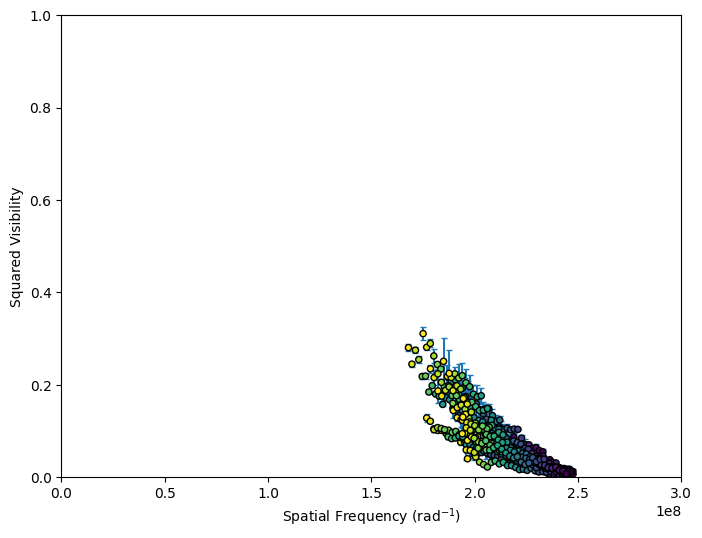

In [12]:
obs.plot();

We can fit these observations with a model, such as a uniform disc model, using the `fit_model` method. Only a limited selection of models have currently been defined, but the source code can be modefied to add more. Alternatively you can define your own function and pass it to the `model` parameter. It's also sensible to pass to `p0` a numpy array that has an initial estimate of the value of each parameter.

In [13]:
obs.fit_model(model='ud',p0=np.array([1.0]))

Now when we use the `plot` method, we see our best-fit model overlaid.

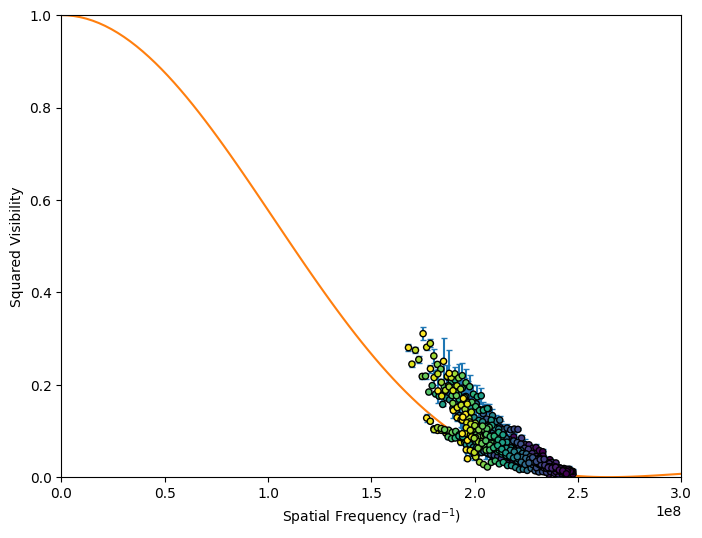

In [14]:
obs.plot();

This doesn't look like a very good fit, but this is an oblate star, so it won't appear to have the same angular diameter if viewed at a different position angle. Instead, we want to fit an angular diameter for each scan. To do this, we run the `fit_model` method with the parameter `individual` set to `True`.

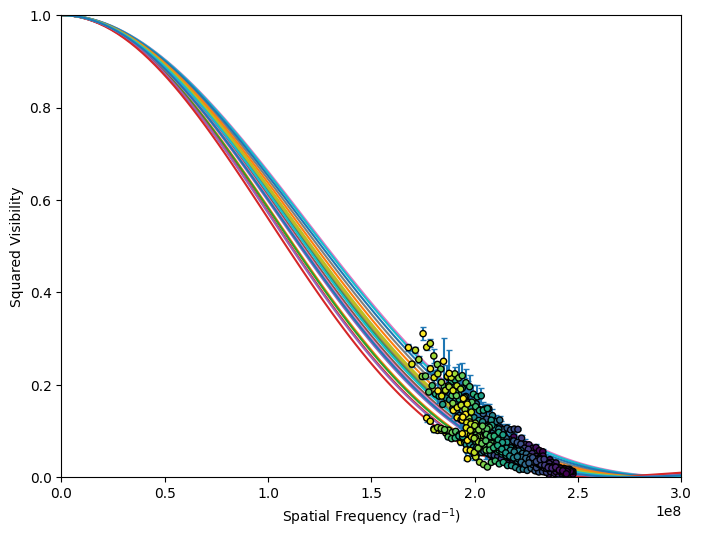

In [15]:
obs.fit_model(model='ud',p0=np.array([1.0]), individual=True)
obs.plot();

Now the plot shows the best fit for each scan. 

Sometimes we'd like to use a more sophistocated models, but keep particular parameters fixed, motivated by other constraints. We can also do this. For example, we can fit linearly limb-darkened diameters keeping the limb darkening coefficient fixed.

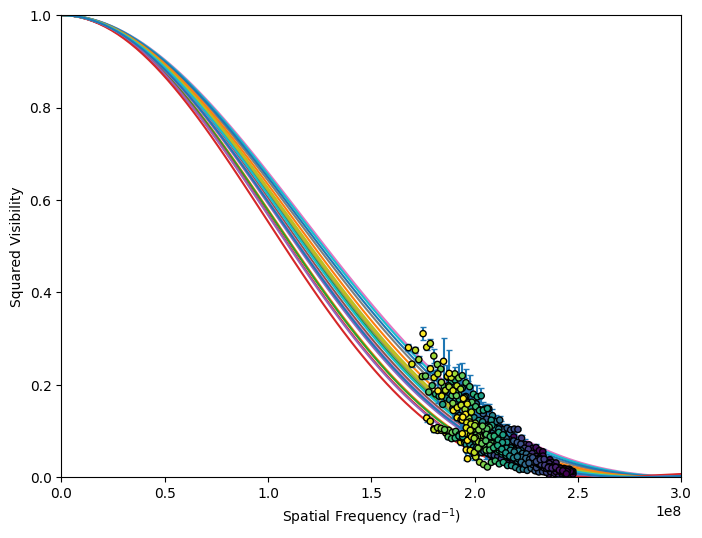

In [16]:
obs.fit_model(model='ld',p0=np.array([1.0,0.5]), fixed=[False,True], individual=True)
obs.plot();

The results of the fit can also be found in the `fit` dictionary list. 

In [17]:
obs.fit

[{'model': <function <lambda>(x, a0)>,
  'parameters': array([0.98958316]),
  'covariance': array([[7.64997841e-06]]),
  'bracket': '210504_6_HD_84999.pav',
  'pa': 131.7882675327552},
 {'model': <function <lambda>(x, a0)>,
  'parameters': array([0.9931276]),
  'covariance': array([[2.52773853e-06]]),
  'bracket': '210504_9_HD_84999.pav',
  'pa': 136.21717613230456},
 {'model': <function <lambda>(x, a0)>,
  'parameters': array([1.00433255]),
  'covariance': array([[6.64430742e-06]]),
  'bracket': '210504_13_HD_84999.pav',
  'pa': 140.36859512866727},
 {'model': <function <lambda>(x, a0)>,
  'parameters': array([1.00779995]),
  'covariance': array([[3.42946249e-06]]),
  'bracket': '210504_16_HD_84999.pav',
  'pa': 142.6374010903523},
 {'model': <function <lambda>(x, a0)>,
  'parameters': array([0.92899724]),
  'covariance': array([[1.10106824e-05]]),
  'bracket': '220313_1_HD_84999.pav',
  'pa': -11.397215614129959},
 {'model': <function <lambda>(x, a0)>,
  'parameters': array([0.868466

Are the different angular diameters for each scan consistent with their position angles? We can make an x-y plot of the angular radii of each scan, and check that it resembles an ellipse.

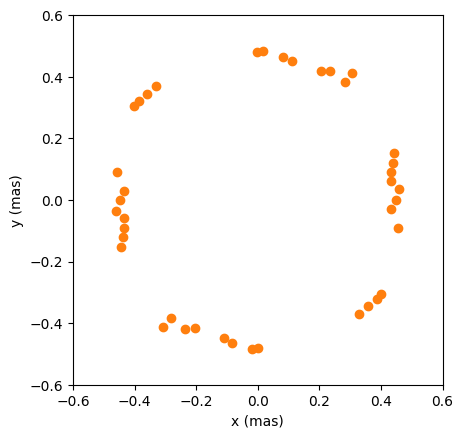

In [18]:
obs.plotxy();

And we can fit an ellipse to these points.

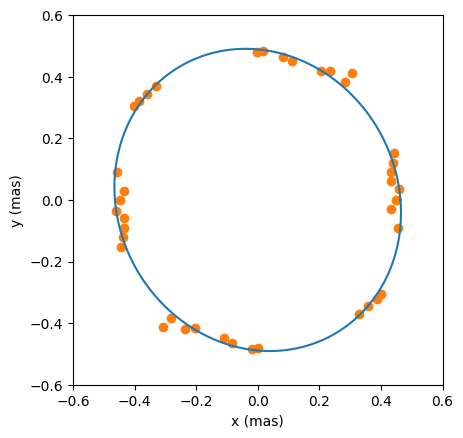

In [19]:
obs.fit_ellipse()
obs.plotxy();

Finally, if we want to get reliable uncertainties, we need to run Monte Carlo simulations that take into account the uncertainty in the calibrator sizes, the wavelength calibration, and observational uncertainties. This step does however take a long time, particularly if we need to do scans individually. For this demonstration, we only run a small number of samples.

In [20]:
obs.fit_mc(config, model='ld',nsamples=36, p0=np.array([1.0,.5]), fixed=[False,True], individual=True)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


At this point our fitted angular diameters will be coloured by position angle, although unfortunately the observations themselves are still coloured by wavlength channel. This should be fixed.

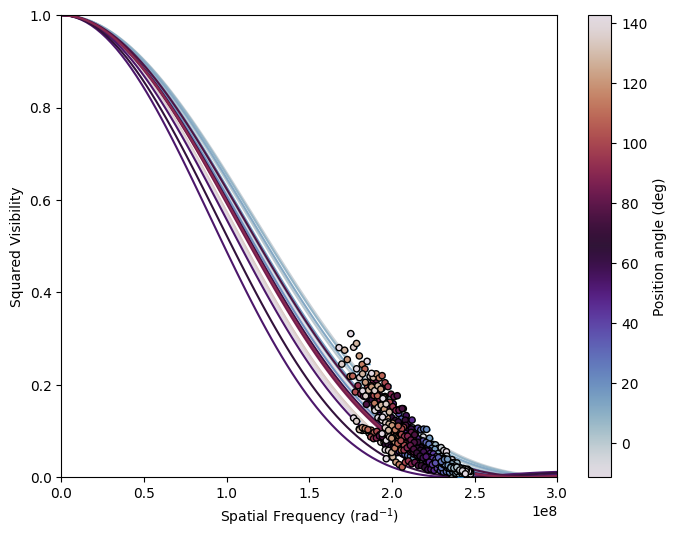

In [21]:
obs.plot(cmap='twilight');

We can access the parameters of the best fitting model, as well as samples from the `mcfit` dictionary.

In [22]:
obs.mcfit

[{'model': <function <lambda>(x, a0)>,
  'samples': array([[0.99356607],
         [1.00023387],
         [1.0074705 ],
         [0.9940372 ],
         [0.9875662 ],
         [0.99235025],
         [0.99600885],
         [0.99470445],
         [0.99337184],
         [0.99484122],
         [0.99358492],
         [1.00176844],
         [0.99797755],
         [1.00000272],
         [1.00333957],
         [1.00334754],
         [0.99792308],
         [0.99176692],
         [0.99892477],
         [0.99834578],
         [0.99750893],
         [0.9983112 ],
         [0.99922023],
         [1.00987913],
         [0.99880928],
         [0.98897977],
         [0.98707581],
         [0.98935872],
         [1.00423207],
         [0.9970069 ],
         [0.9930022 ],
         [0.98481762],
         [0.99061075],
         [0.99116939],
         [0.99820814],
         [0.98701575]]),
  'mean': array([0.99600938]),
  'std': array([0.00574588]),
  'median': array([0.99650787]),
  'upper': array([0.004393

There are a number of improvements to be made - from improving the efficieny of the MC fitting to allowing for more sophisticated models. But it's a start, and hopefully this tutorial has been useful.